# Attention Map Visualization / Graph Reconstruction

This notebook creates two image files that visualize attention maps as both heatmaps and network graphs, helping us observe attention behavior in-depth.

#### 1. Model Implementation

In [1]:
import math
import torch
from torch import nn

In [2]:
class FeatureEmbedder(nn.Module):
    def __init__(self, args):
        """Args:
        vocab_sizes: A dictionary of vocabularize sizes for each feature. (e.g.{'dx_ints': 1001, 'proc_ints': 1001, 'lab_ints': 1001})
        feature_keys: A list of feature names you want to use.
        embedding_size: The dimension size of the feature representation vector.
        """
        super().__init__()
        self.embeddings = {}
        self.feature_keys = args.feature_keys

        self.dx_embeddings = nn.Embedding(args.vocab_sizes['dx_ints'] + 1, args.hidden_size,
                                          padding_idx=args.vocab_sizes['dx_ints'])
        self.proc_embeddings = nn.Embedding(args.vocab_sizes['proc_ints'] + 1, args.hidden_size,
                                            padding_idx=args.vocab_sizes['proc_ints'])
        self.visit_embeddings = nn.Embedding(1, args.hidden_size)

        self.layernorm = nn.LayerNorm(args.hidden_size)
        self.dropout = nn.Dropout(args.hidden_dropout_prob)

    def forward(self, features):
        """
        embeddings: A dictionary of dense representation Tensors for each feature.
        masks: A dictionary of dense float32 Tensors for each feature, that will be used as a mask in the downstream tasks."""

        batch_size = features[self.feature_keys[0]].shape[0]
        embeddings = {}
        masks = {}

        embeddings['dx_ints'] = self.dx_embeddings(features['dx_ints']) # pass diagnoses ints to embedding layer
        embeddings['proc_ints'] = self.proc_embeddings(features['proc_ints']) # pass treatment ints to embedding layer
        device = features['dx_ints'].device

        embeddings['visit'] = self.visit_embeddings(torch.tensor([0]).to(device))
        embeddings['visit'] = embeddings['visit'].unsqueeze(0).expand(batch_size, -1, -1)
        masks['visit'] = torch.ones(batch_size, 1).to(device)
        for name, embedding in embeddings.items():
            embeddings[name] = self.layernorm(embedding)
            embeddings[name] = self.dropout(embeddings[name])

        return embeddings, masks

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, args, stack_idx):
        super().__init__()
        self.stack_idx = stack_idx
        self.num_attention_heads = args.num_heads
        self.attention_head_size = int(args.hidden_size / args.num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size # ~ hidden size

        self.query = nn.Linear(args.hidden_size, self.all_head_size)
        self.key = nn.Linear(args.hidden_size, self.all_head_size)
        self.value = nn.Linear(args.hidden_size, self.all_head_size)
        # experiment with dropout after completion
        # self.dropout = nn.Dropout(args.hidden_dropout_prob)

    def transpose_for_scores(self, x):
        """ This method reshapes the input tensor for the self-attention calculation, which involves taking the dot product between the query and key vectors, scaled by the square root of the attention head size. """
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask=None, guide_mask=None, prior=None, output_attentions=True):
        if self.stack_idx == 0 and prior is not None:
            """ If prior probabilities are given and this is the first layer of the model (stack_idx == 0), 
            the prior probabilities are used instead of computing new attention probabilities. """
            attention_probs = prior[:, None, :, :].expand(-1, self.num_attention_heads, -1, -1)
        else:
            # computes key and query
            mixed_query_layer = self.query(hidden_states)
            mixed_key_layer = self.key(hidden_states)
            # transpose for calculation
            query_layer = self.transpose_for_scores(mixed_query_layer)
            key_layer = self.transpose_for_scores(mixed_key_layer)
            # take dot product between query and key to get raw attention scores
            attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
            attention_scores = attention_scores / math.sqrt(self.attention_head_size)
            if attention_mask is not None:
                attention_scores = attention_scores + attention_mask # add attention mask
            attention_probs = nn.Softmax(dim=-1)(attention_scores)

        mixed_value_layer = self.value(hidden_states)
        value_layer = self.transpose_for_scores(mixed_value_layer) # compute values

        # dropping out entire tokens to attend to; extra experiment
        # attention_probs = self.dropout(attention_probs)

        # get context vector
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        return outputs

In [4]:
class SelfOutput(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.dense = nn.Linear(args.hidden_size, args.hidden_size)
        self.layer_norm = nn.LayerNorm(args.hidden_size)
        self.dropout = nn.Dropout(args.hidden_dropout_prob)
        self.activation = nn.ReLU()

    def forward(self, hidden_states, input_tensor):
        """input: 
        the output of the self-attention calculation (hidden_states), the original input tensor (input_tensor)
        Here, the input tensor is used to add a residual connection to the output of the self-attention calculation. """
        hidden_states = self.activation(self.dense(hidden_states))
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.layer_norm(hidden_states + input_tensor)
        return hidden_states

In [5]:
class Attention(nn.Module):
    def __init__(self, args, stack_idx):
        super().__init__()
        self.self_attention = SelfAttention(args, stack_idx)
        self.self_output = SelfOutput(args)

    def forward(self, hidden_states, attention_mask, guide_mask=None, prior=None, output_attentions=True):
        self_attention_outputs = self.self_attention(hidden_states, attention_mask, guide_mask, prior,
                                                     output_attentions) # returns attention output

        attention_output = self.self_output(self_attention_outputs[0], hidden_states) # adds the original hidden states as a residual connection, and normalizes the result
        outputs = (attention_output,) + self_attention_outputs[1:]
        return outputs

In [6]:
class GCTLayer(nn.Module):
    def __init__(self, args, stack_idx):
        super().__init__()
        self.attention = Attention(args, stack_idx)
        # self.intermediate = IntermediateLayer(args)
        # self.output = OutputLayer(args)

    def forward(self, hidden_states, attention_mask=None, guide_mask=None, prior=None, output_attentions=True):
        self_attention_outputs = self.attention(hidden_states, attention_mask, guide_mask, prior, output_attentions)
        attention_output = self_attention_outputs[0] # context_layer
        outputs = self_attention_outputs[1:] # attention_prob

        # intermediate_output = self.intermediate(attention_output)
        # layer_output = self.output(intermediate_output, attention_output)

        # outputs = (layer_output,) + outputs
        outputs = (attention_output,) + outputs
        return outputs

In [7]:
class Pooler(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.dense = nn.Linear(args.hidden_size, args.hidden_size)
        self.activation = nn.ReLU()

    def forward(self, hidden_states):
        first_token_tensor = hidden_states[:, 0] # extracts the first token tensor 
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

In [8]:
class GraphConvolutionalTransformer(nn.Module):
    """
    Args:
      feature_keys: A list of feature names you want to use. (e.g. ['dx_ints,'proc_ints', 'lab_ints'])
      max_num_codes: The maximum number of how many feature there can be inside
        a single visit, per feature. For example, if this is set to 50, then we
        are assuming there can be up to 50 diagnosis codes, 50 treatment codes,
        and 50 lab codes. This will be used for creating the prior matrix.
      prior_scalar: A float value between 0.0 and 1.0 to be used to hard-code the diagnoal elements of the prior matrix.
      reg_coef: A coefficient to decide the KL regularization balance when training GCT.
      batch_size: Batch size.
    """
    def __init__(self, args):
        super(GraphConvolutionalTransformer, self).__init__()
        self.num_labels = args.num_labels
        self.label_key = args.label_key
        self.reg_coef = args.reg_coef
        self.use_guide = args.use_guide
        self.use_prior = args.use_prior
        self.prior_scalar = args.prior_scalar
        self.batch_size = args.batch_size
        self.num_stacks = args.num_stacks
        self.max_num_codes = args.max_num_codes
        self.output_attentions = args.output_attentions
        self.output_hidden_states = args.output_hidden_states
        self.feature_keys = args.feature_keys
        self.layers = nn.ModuleList([GCTLayer(args, i) for i in range(args.num_stacks)])
        self.embeddings = FeatureEmbedder(args)
        self.pooler = Pooler(args)

        # self.dropout = nn.Dropout(args.hidden_dropout_prob)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(args.hidden_size, args.num_labels)

        self.output_dir = args.output_dir

    def create_matrix_vdp(self, features, masks, priors):
        """vdp indicate your features are diagnosis codes and treatment codes only.
        This function creates the guide matrix and the prior matrix when visits include diagnosis codes, treatment codes, but not lab codes.

        Args:
            features: A dictionary of SparseTensors for each feature.
            mask: 3D float Tensor of size (batch_size, num_features, 1). This holds binary values to indicate the parts that are padded.
        Returns:
            guide: The guide matrix.
            prior_guide: The conditional probablity matrix.
        """
        batch_size = features['dx_ints'].shape[0]
        device = features['dx_ints'].device
        num_dx_ids = self.max_num_codes if self.use_prior else features['dx_ints'].shape[-1]
        num_proc_ids = self.max_num_codes if self.use_prior else features['proc_ints'].shape[-1]
        num_codes = 1 + num_dx_ids + num_proc_ids

        guide = None
        prior_guide = None

        # If use_guide is True, it creates a guide matrix that encodes the dependencies between diagnosis codes and treatment codes.
        if self.use_guide:
            row0 = torch.cat([torch.zeros([1, 1]), torch.ones([1, num_dx_ids]), torch.zeros([1, num_proc_ids])], axis=1)
            row1 = torch.cat([torch.zeros([num_dx_ids, num_dx_ids + 1]), torch.ones([num_dx_ids, num_proc_ids])],
                             axis=1)
            row2 = torch.zeros([num_proc_ids, num_codes])

            guide = torch.cat([row0, row1, row2], axis=0)
            guide = guide + guide.t()
            guide = guide.to(device)

            guide = guide.unsqueeze(0)
            guide = guide.expand(batch_size, -1, -1)
            guide = (guide * masks.unsqueeze(-1) * masks.unsqueeze(1) + torch.eye(num_codes).to(device).unsqueeze(0))
        
        # If use_prior is True, it creates a prior guide matrix based on the prior knowledge provided.
        if self.use_prior:
            prior_idx = priors['indices'].t()
            temp_idx = (prior_idx[:, 0] * 100000 + prior_idx[:, 1] * 1000 + prior_idx[:, 2])
            sorted_idx = torch.argsort(temp_idx)
            prior_idx = prior_idx[sorted_idx]

            prior_idx_shape = [batch_size, self.max_num_codes * 2, self.max_num_codes * 2]
            sparse_prior = torch.sparse.FloatTensor(prior_idx.t(), priors['values'], torch.Size(prior_idx_shape))
            prior_guide = sparse_prior.to_dense()

            visit_guide = torch.tensor([self.prior_scalar] * self.max_num_codes + [0.0] * self.max_num_codes * 1,
                                       dtype=torch.float, device=device)
            prior_guide = torch.cat([visit_guide.unsqueeze(0).unsqueeze(0).expand(batch_size, -1, -1), prior_guide],
                                    axis=1)
            visit_guide = torch.cat([torch.tensor([0.0], device=device), visit_guide], axis=0)
            prior_guide = torch.cat([visit_guide.unsqueeze(0).unsqueeze(-1).expand(batch_size, -1, -1), prior_guide],
                                    axis=2)
            prior_guide = (prior_guide * masks.unsqueeze(-1) * masks.unsqueeze(1) + self.prior_scalar * torch.eye(
                num_codes, device=device).unsqueeze(0))
            degrees = torch.sum(prior_guide, axis=2)
            prior_guide = prior_guide / degrees.unsqueeze(-1)

        return guide, prior_guide

    def get_loss(self, logits, labels, attentions): # computes crossEntropyLoss
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if self.use_prior: # If prior is used, we regularize loss function by KL regularization. This prevents the self-attention values becoming too novel from prior knowledge.
            kl_terms = []
            for i in range(1, self.num_stacks):
                log_p = torch.log(attentions[i - 1] + 1e-12)
                log_q = torch.log(attentions[i] + 1e-12)
                kl_term = attentions[i - 1] * (log_p - log_q)
                kl_term = torch.sum(kl_term, axis=-1)
                kl_term = torch.mean(kl_term)
                kl_terms.append(kl_term)
            reg_term = torch.mean(torch.tensor(kl_terms))
            loss += self.reg_coef * reg_term
        return loss

    def forward(self, data, priors_data):
        embedding_dict, mask_dict = self.embeddings(data)
        mask_dict['dx_ints'] = data['dx_masks']
        mask_dict['proc_ints'] = data['proc_masks']

        keys = ['visit'] + self.feature_keys
        hidden_states = torch.cat([embedding_dict[key] for key in keys], axis=1)
        masks = torch.cat([mask_dict[key] for key in keys], axis=1)

        guide, prior_guide = self.create_matrix_vdp(data, masks, priors_data)

        all_hidden_states = () if self.output_hidden_states else None
        all_attentions = () if self.output_attentions else None
        # make attention_mask, guide_mask
        extended_attention_mask = get_extended_attention_mask(masks)
        extended_guide_mask = get_extended_attention_mask(guide) if self.use_guide else None

        for i, layer_module in enumerate(self.layers):
            if self.output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = layer_module(hidden_states, extended_attention_mask, extended_guide_mask, prior_guide,
                                         self.output_attentions)
            hidden_states = layer_outputs[0]
            if self.output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],) # = (layer_outputs[1])
        if self.output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        pooled_output = self.pooler(hidden_states)
        # pooled_output = hidden_states[:,0]

        # get logits and loss
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        loss = self.get_loss(logits, data[self.label_key], all_attentions)

        return tuple(v for v in [loss, logits, all_hidden_states, all_attentions] if v is not None)

#### 2. Define auxiliary functions for training and parameters

In [9]:
import torch
import numpy as np
import os
import logging
from tqdm import tqdm, trange
from utils import *

from tensorboardX import SummaryWriter

In [10]:
fold = 0
data_dir = "eicu_data"
fold_path = os.path.join(data_dir, 'fold_{}'.format(fold))
cached_path = os.path.join(fold_path, 'cached')

train_dataset = torch.load(os.path.join(cached_path, 'train_dataset.pt'))
eval_dataset = torch.load(os.path.join(cached_path, 'valid_dataset.pt'))
test_dataset = torch.load(os.path.join(cached_path, 'test_dataset.pt'))

train_priors = torch.load(os.path.join(cached_path, 'train_priors.pt'))
eval_priors = torch.load(os.path.join(cached_path, 'valid_priors.pt'))
test_priors = torch.load(os.path.join(cached_path, 'test_priors.pt'))

In [11]:
def prediction_loop(args, model, dataloader, priors_datalaoder, description='Evaluating'):
    batch_size = dataloader.batch_size
    eval_losses = []
    preds = None
    label_ids = None
    model.eval() # set model mode as evaluation mode

    for data, priors_data in tqdm(zip(dataloader, priors_datalaoder), desc=description): 
        # Iterates over batches of data from the dataloader and priors_dataloader
        data, priors_data = prepare_data(data, priors_data, args.device)
        with torch.no_grad():
            outputs = model(data, priors_data)
            loss = outputs[0].mean().item()
            logits = outputs[1]

        labels = data[args.label_key]

        batch_size = data[list(data.keys())[0]].shape[0]
        eval_losses.extend([loss] * batch_size)
        preds = logits if preds is None else nested_concat(preds, logits, dim=0)
        label_ids = labels if label_ids is None else nested_concat(label_ids, labels, dim=0)

    if preds is not None:
        preds = nested_numpify(preds)
    if label_ids is not None:
        label_ids = nested_numpify(label_ids)
    metrics = compute_metrics(preds, label_ids)

    metrics['eval_loss'] = np.mean(eval_losses) # update loss value as mean of loss per a batch

    for key in list(metrics.keys()):
        if not key.startswith('eval_'):
            metrics['eval_{}'.format(key)] = metrics.pop(key)

    return metrics # return metrics dictionary

In [12]:
class Args:
    pass

args = Args()
args.num_labels = 2 # default
args.label_key = 'readmission'
args.reg_coef = 0.1
args.use_guide = True
args.use_prior = True
args.prior_scalar = 0.5 # default
args.batch_size = 32
args.num_stacks = 1
args.max_num_codes = 50 # default
args.output_attentions = True
args.output_hidden_states = True
args.feature_keys = ['dx_ints', 'proc_ints'] # default
args.hidden_size = 128 # default
args.num_heads = 1 # default
args.hidden_dropout_prob = 0.08
args.vocab_sizes = {'dx_ints':3249, 'proc_ints':2210} # default
args.learning_rate = 0.00022
args.max_steps=100 # default 100000
args.output_dir=f'test_output/model_{args.learning_rate}_{args.hidden_dropout_prob}_{args.label_key}'
args.do_train = True
args.do_eval = False
args.do_test = False
args.warmup = 0.05 # default
args.intermediate_size = 256 # default
args.eps = 1e-8 # default
args.max_grad_norm = 1.0 # default
args.eval_batch_size = 3  
args.logging_steps=100 # default
args.num_train_epochs = 0 # default
args.seed = 42 # default

In [13]:
set_seed(args.seed)

In [14]:
def get_summary(model): # This prints out the setting information of model parameters
    total_params = 0
    for name, param in model.named_parameters():
        shape = param.shape
        param_size = 1
        for dim in shape:
            param_size *= dim
        print(name, shape, param_size)
        total_params += param_size
    print(total_params)

In [15]:
# Store the log data
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO
)

logger = logging.getLogger(__name__)

if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)
logging_dir = os.path.join(args.output_dir, 'logging')
if not os.path.exists(logging_dir):
    os.makedirs(logging_dir)
tb_writer = SummaryWriter(log_dir=logging_dir)

### Define Visualization Function

The ```visualize_attention()``` function saves both heatmap and network graph image files under the *img_dir* folder, which is passed as an input parameter in the training script. The detailed explanation is provided in the comments alongside the code lines

In [16]:
## Code reference: https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
### Added y-axis ticks
def wrap_labels(ax, x_width, y_width, break_long_words=False):
    import textwrap
    # This function wraps the text automatically when there are long x/y-axis tick labels
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=x_width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=y_width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=90)

# This function assumes feature_keys = ['dx_ints', 'proc_ints'] 
## If you want ['lab_ints'] as one of feature_keys, you should add some code lines below
def visualize_attention(args, data, dx_map, proc_map, img_dir, attention_maps):
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    
    rv_dx_map = {y: x.split("|")[-1] for x, y in dx_map.items()} # long diagnosis name so get the last element
    rv_proc_map = {y: x.split("|")[-1] for x, y in proc_map.items()} # long treatment name so get the last element

    batch_size, _, _ = attention_maps.shape # (batch_size, 2*max_num_codes+1, 2*max_num_codes+1)
    
    # data.keys(): ['dx_ints', 'proc_ints', 'dx_masks', 'proc_masks', 'readmission', 'expired']
    dx_ints = data['dx_ints'] # PyTorch tensor of size (batch_size, max_num_codes)
    proc_ints = data['proc_ints'] # PyTorch tensor of size (batch_size, max_num_codes)
    dx_masks = data['dx_masks'] # PyTorch tensor of size (batch_size, max_num_codes)
    proc_masks = data['proc_masks'] # PyTorch tensor of size (batch_size, max_num_codes)

    viz_batch_idxs = []
    for i in range(batch_size): # for compact visualization
        dx_ints_actual = dx_ints[i][dx_masks[i] == 1]
        proc_ints_actual = proc_ints[i][proc_masks[i] == 1]
        if dx_ints_actual.shape[0]+proc_ints_actual.shape[0] <= 12: # to fit the figsize, only 12 under actual codes can be annotated
            viz_batch_idxs.append(i)

    if len(viz_batch_idxs) > 5: # for compact visualization
        viz_batch_idxs = viz_batch_idxs[:4] # draw first 4 batches only
    
    if len(viz_batch_idxs) == 0:
        print("Cannot visualize attention map because there are so many actual codes. Please try another max_steps value.")
        return
    
    fig, axs = plt.subplots(ncols=len(viz_batch_idxs), nrows=1, figsize=(12*len(viz_batch_idxs), 12*len(viz_batch_idxs)), layout="constrained") # need to increase fig size properly
    
    for i, v in enumerate(viz_batch_idxs):
        attention_map = attention_maps[v]
        
        # Slice actual values for dx_ints and proc_ints
        dx_ints_actual = dx_ints[v][dx_masks[v] == 1]
        proc_ints_actual = proc_ints[v][proc_masks[v] == 1]
        dx_ints_idx = dx_ints_actual.shape[0]
        proc_ints_idx = proc_ints_actual.shape[0]
    
        # Slice Attention Map to get actual values
        actual_attn_map1 = attention_map[:dx_ints_idx+1, :dx_ints_idx+1]
        proc_ints_idx1 = args.max_num_codes + 1
        proc_ints_idx2 = args.max_num_codes + proc_ints_idx + 1
        actual_attn_map2 = attention_map[proc_ints_idx1:proc_ints_idx2, proc_ints_idx1:proc_ints_idx2]
        actual_attn_map3 = attention_map[proc_ints_idx1:proc_ints_idx2, :dx_ints_idx+1]
        actual_attn_map4 = attention_map[:dx_ints_idx+1, proc_ints_idx1:proc_ints_idx2]
        
        # Concatenate dx_ints and proc_ints with torch.tensor([0])
        #mask = torch.cat([torch.tensor([0]), dx_masks[i], proc_masks[i]]).bool()
        #attention_map_actual = np.diag(attention_map[mask,mask]) # for 1d
        
        # Slice actual values for attention_map
        attention_map_actual = np.zeros((dx_ints_idx+proc_ints_idx+1, dx_ints_idx+proc_ints_idx+1))
        attention_map_actual[:dx_ints_idx+1, :dx_ints_idx+1] = actual_attn_map1
        attention_map_actual[dx_ints_idx+1:, dx_ints_idx+1:] = actual_attn_map2
        attention_map_actual[dx_ints_idx+1:, :dx_ints_idx+1] = actual_attn_map3
        attention_map_actual[:dx_ints_idx+1, dx_ints_idx+1:] = actual_attn_map4
        
        labels = ['visit',]+['D_'+rv_dx_map[v.item()] for v in dx_ints_actual] + ['T_'+rv_proc_map[v.item()] for v in proc_ints_actual]
        
        if len(viz_batch_idxs) > 1:
            ax = axs[i]     
        else:
            ax = axs
        
        # Plot heatmap
        ax.imshow(attention_map_actual, cmap='Blues', vmin=0, vmax=1)
        ax.yaxis.set_ticks(range(attention_map_actual.shape[0]))
        ax.xaxis.set_ticks(range(attention_map_actual.shape[1]))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        wrap_labels(ax, 10, 7, True)
        ax.set_title(f'Batch {v+1}')

    # Put colorbar on the right side
    if len(viz_batch_idxs) > 1:
        fig.colorbar(axs[0].images[0], fraction=0.02, ax=axs.ravel().tolist())
    else:
        fig.colorbar(axs.images[0])
        
    plt.savefig(img_dir+'_hm', bbox_inches='tight') # save image
    plt.show()


    ### Network Graph
    import networkx as nx
    num_cols = len(viz_batch_idxs) if len(viz_batch_idxs) < 3 else 3 # Number of columns of graphs
    num_rows = (len(viz_batch_idxs) - 1) // num_cols + 1 # Number of rows of graphs
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*7, num_rows*5))

    for i, v in enumerate(viz_batch_idxs):
        attention_map = attention_maps[v]
        
        # Slice actual values for dx_ints and proc_ints
        dx_ints_actual = dx_ints[v][dx_masks[v] == 1]
        proc_ints_actual = proc_ints[v][proc_masks[v] == 1]
        dx_ints_idx = dx_ints_actual.shape[0]
        proc_ints_idx = proc_ints_actual.shape[0]
    
        # Slice Attention Map to get actual values
        actual_attn_map1 = attention_map[:dx_ints_idx+1, :dx_ints_idx+1]
        proc_ints_idx1 = args.max_num_codes + 1
        proc_ints_idx2 = args.max_num_codes + proc_ints_idx + 1
        actual_attn_map2 = attention_map[proc_ints_idx1:proc_ints_idx2, proc_ints_idx1:proc_ints_idx2]
        actual_attn_map3 = attention_map[proc_ints_idx1:proc_ints_idx2, :dx_ints_idx+1]
        actual_attn_map4 = attention_map[:dx_ints_idx+1, proc_ints_idx1:proc_ints_idx2]
        
        # Concatenate dx_ints and proc_ints with torch.tensor([0])
        #mask = torch.cat([torch.tensor([0]), dx_masks[i], proc_masks[i]]).bool()
        #attention_map_actual = np.diag(attention_map[mask,mask]) # for 1d
        
        # Slice actual values for attention_map
        attention_map_actual = np.zeros((dx_ints_idx+proc_ints_idx+1, dx_ints_idx+proc_ints_idx+1))
        attention_map_actual[:dx_ints_idx+1, :dx_ints_idx+1] = actual_attn_map1
        attention_map_actual[dx_ints_idx+1:, dx_ints_idx+1:] = actual_attn_map2
        attention_map_actual[dx_ints_idx+1:, :dx_ints_idx+1] = actual_attn_map3
        attention_map_actual[:dx_ints_idx+1, dx_ints_idx+1:] = actual_attn_map4
        
        labels = ['visit',]+['D_'+rv_dx_map[v.item()] for v in dx_ints_actual] + ['T_'+rv_proc_map[v.item()] for v in proc_ints_actual]
        
        # Create a graph
        G = nx.DiGraph()
        num_nodes = len(labels)
        for j in range(num_nodes):
            G.add_node(labels[j])
        for j in range(num_nodes):
            for k in range(num_nodes):
                if attention_map_actual[j, k] > 0:
                    G.add_edge(labels[j], labels[k], weight=attention_map_actual[j, k])
        
        # Set the position of each node manually
        pos = {} #labels[0]: (0, 1)
        for num in range(num_nodes):
            angle = 2 * np.pi * (num-1) / (num_nodes)
            x, y = np.sin(angle), np.cos(angle)
            pos[labels[num]] = (x, y)
        
        # Draw the graph
        #pos = nx.shell_layout(G)
        edge_weights = [round(w, 3) for w in nx.get_edge_attributes(G, 'weight').values()]
        edge_labels = {e: f'{w:.3f}' for e, w in nx.get_edge_attributes(G, 'weight').items()}

        # Remove self-loops
        self_loops = [(u, v) for u, v in G.edges() if u == v]
        if self_loops:
            G.remove_edges_from(self_loops)
        
        row_idx = i // num_cols
        col_idx = i % num_cols

        # Define axis
        if len(viz_batch_idxs) > 1:
            if len(viz_batch_idxs) > 3:
                ax = axs[row_idx, col_idx]
            else:
                ax = axs[col_idx]
        else:
            ax = axs
        ax.set_title(f'Batch {v+1}')

        nx.draw_networkx_nodes(G, pos, node_size=100, node_color='skyblue', ax=ax)
        nx.draw_networkx_edges(G, pos, width=edge_weights*100, arrows=False, edge_cmap='Blues', ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=7, font_family='sans-serif', ax=ax)
        #nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=4) # add edge labels

    for row in range(num_rows):
        for col in range(num_cols):
            axs[row][col].axis('off')

    #plt.axis('off')
    plt.savefig(img_dir+'_gx', bbox_inches='tight')
    plt.show()


05/04/2023 16:22:06 - INFO - __main__ - ***** Running Training *****
05/04/2023 16:22:06 - INFO - __main__ -  Num examples = 32820
05/04/2023 16:22:06 - INFO - __main__ -  Num epochs = 1
05/04/2023 16:22:06 - INFO - __main__ -  Train batch size = 32
05/04/2023 16:22:06 - INFO - __main__ -  Total optimization steps = 100
Epoch: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


{'loss': nan, 'learning_rate': 0.0, 'step': 100}


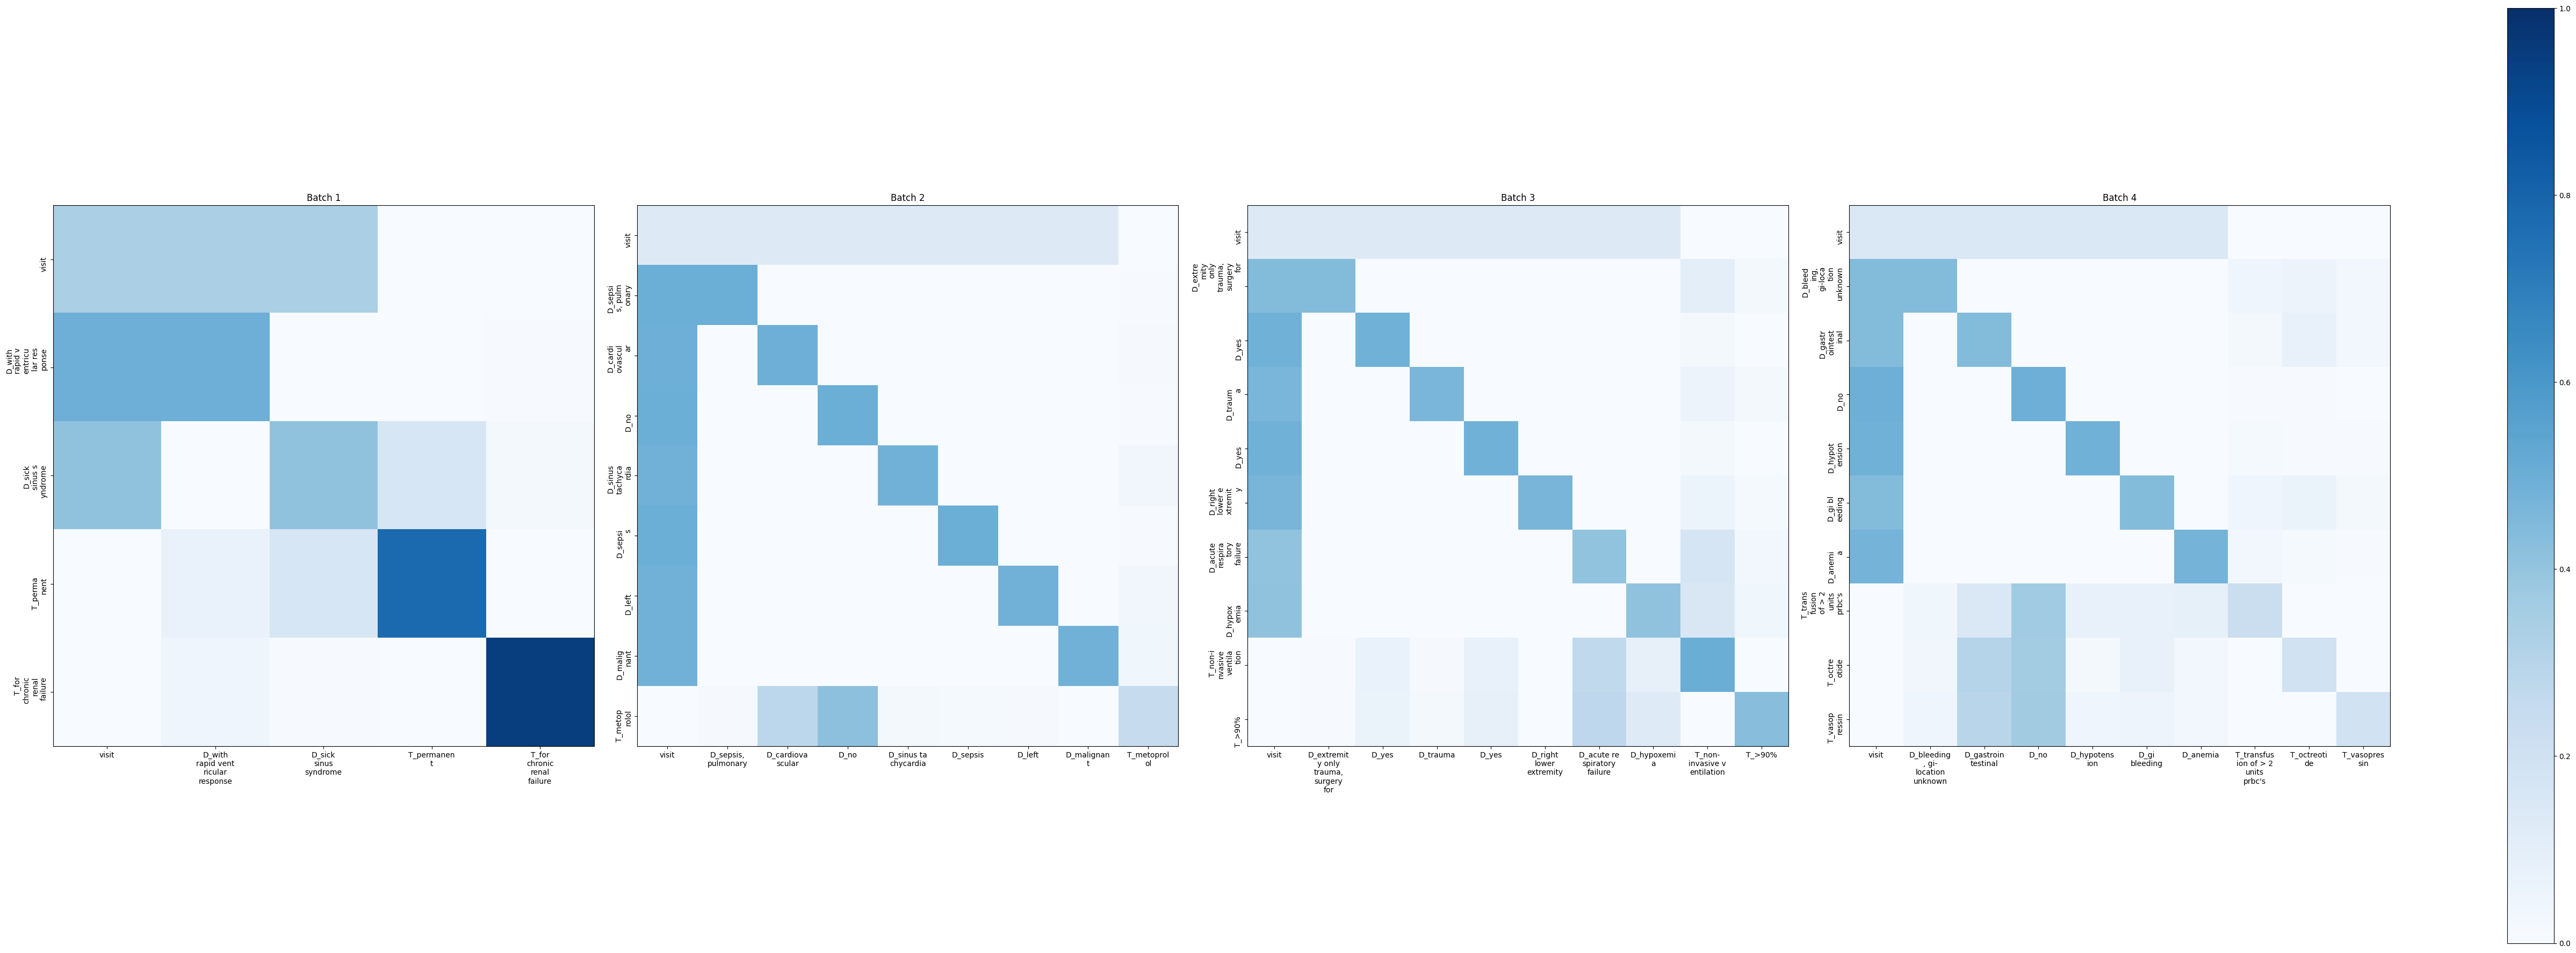

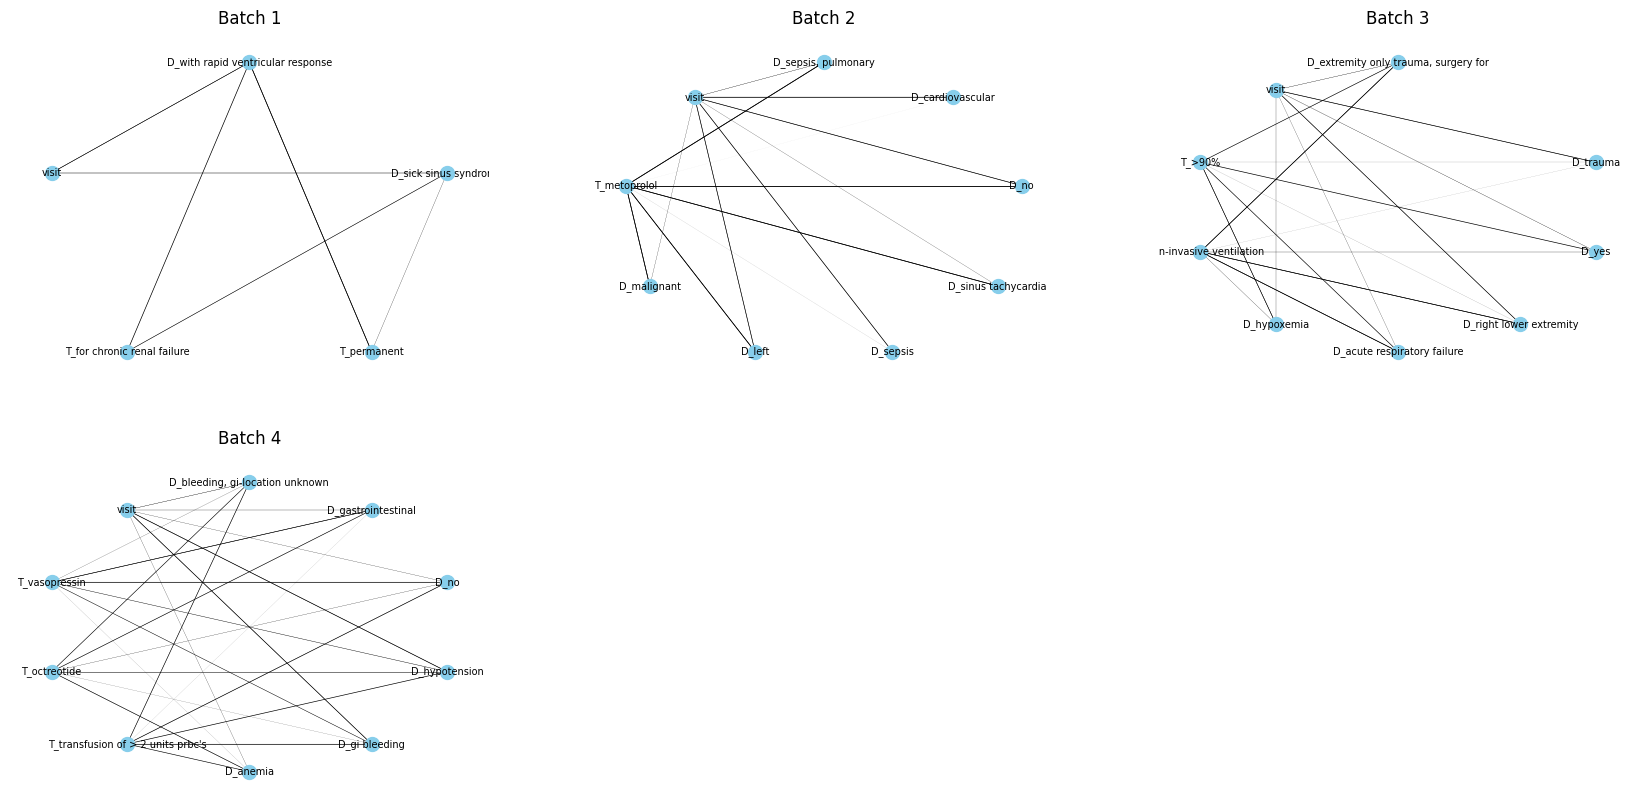

05/04/2023 16:22:15 - INFO - root - 

Training completed


In [17]:
# Dataset handling
train_priors_dataset = eICUPriorDataset(train_priors)
eval_priors_dataset = eICUPriorDataset(eval_priors)
test_priors_dataset = eICUPriorDataset(test_priors)

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size)
eval_dataloader = DataLoader(eval_dataset, batch_size=args.batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size)

train_priors_dataloader = DataLoader(train_priors_dataset, batch_size=args.batch_size, collate_fn=priors_collate_fn)
eval_priors_dataloader = DataLoader(eval_priors_dataset, batch_size=args.batch_size, collate_fn=priors_collate_fn)
test_priors_dataloader = DataLoader(test_priors_dataset, batch_size=args.batch_size, collate_fn=priors_collate_fn)

# Check GPU Resource
args.n_gpu = torch.cuda.device_count()
args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if args.device.type == 'cuda':
    torch.cuda.set_device(args.device)
    logger.info('***** Using CUDA device *****')

if args.do_train:
    model = GraphConvolutionalTransformer(args)
    model = model.to(args.device)

    num_update_steps_per_epoch = len(train_dataloader)
    if args.max_steps > 0:
        max_steps = args.max_steps
        num_train_epochs = max_steps // num_update_steps_per_epoch + int(max_steps % num_update_steps_per_epoch > 0)
    else:
        max_steps = int(num_update_steps_per_epoch * args.num_train_epochs)
        num_train_epochs = args.num_train_epochs
    num_train_epochs = int(np.ceil(num_train_epochs))

    args.eval_steps = num_update_steps_per_epoch // 2

    # also try Adamax
    # optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, betas=(0.9,0.999), eps=args.eps)
    optimizer = torch.optim.Adamax(model.parameters(), lr=args.learning_rate)
    warmup_steps = max_steps // (1 / args.warmup)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, num_training_steps=max_steps)

    # if tb_writer:
    #     tb_writer.add_text('args', json.dumps(vars(args), indent=2, sort_keys=True))

    logger.info('***** Running Training *****')
    logger.info(' Num examples = {}'.format(len(train_dataloader.dataset)))
    logger.info(' Num epochs = {}'.format(num_train_epochs))
    logger.info(' Train batch size = {}'.format(args.batch_size))
    logger.info(' Total optimization steps = {}'.format(max_steps))

    epochs_trained = 0
    global_step = 0
    tr_loss = torch.tensor(0.0).to(args.device)
    logging_loss_scalar = 0.0
    model.zero_grad()

    train_pbar = trange(epochs_trained, num_train_epochs, desc='Epoch')
    for epoch in range(epochs_trained, num_train_epochs): # Iterate over Epoch
        epoch_pbar = tqdm(train_dataloader, desc='Iteration')
        for data, priors_data in zip(train_dataloader, train_priors_dataloader):
            model.train()
            data, priors_data = prepare_data(data, priors_data, args.device)
            
            outputs = model(data, priors_data)
            loss = outputs[0]

            if args.n_gpu > 1:
                loss = loss.mean()
            loss.backward()

            tr_loss += loss.detach()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
            optimizer.step()
            scheduler.step()
            model.zero_grad()
            global_step += 1

            if (args.logging_steps > 0 and global_step % args.logging_steps == 0):
                logs = {}
                tr_loss_scalar = tr_loss.item()
                logs['loss'] = (tr_loss_scalar - logging_loss_scalar) / args.logging_steps
                logs['learning_rate'] = scheduler.get_last_lr()[0]
                logging_loss_scalar = tr_loss_scalar
                if tb_writer:
                    for k, v in logs.items():
                        if isinstance(v, (int, float)):
                            tb_writer.add_scalar(k, v, global_step)
                    tb_writer.flush()
                output = {**logs, **{"step": global_step}}
                print(output)

            if (args.eval_steps > 0 and global_step % args.eval_steps == 0):
                metrics = prediction_loop(args, model, eval_dataloader, eval_priors_dataloader)
                logger.info('**** Checkpoint Eval Results ****')
                for key, value in metrics.items():
                    logger.info('{} = {}'.format(key, value))
                    tb_writer.add_scalar(key, value, global_step)

            epoch_pbar.update(1)
            if global_step >= max_steps:
                break

        epoch_pbar.close()
        train_pbar.update(1)
        if global_step >= max_steps:
            break

    train_pbar.close()
    if tb_writer:
        tb_writer.close()

    # Visualize Attention Map
    attn_probs = outputs[-1][-1] # the last element in output tuple, if you specify num_of_stacks > 1 then this would return the last stack attention
    head_idx = 0 # original paper used one-head attention. If you specified num_of_heads more than 1, then you can change this value.
    attention_map = attn_probs[:, head_idx, :, :].detach().numpy() # [batch_idx, head_idx, input_token_idx, output_token_idx]

    # Read map pickle files
    import pickle
    with open(f'{fold_path}/dx_map.p', 'rb') as f:
        dx_map = pickle.load(f)
    with open(f'{fold_path}/proc_map.p', 'rb') as f:
        proc_map = pickle.load(f)
    
    # Specify the image directory
    img_dir = f'{args.output_dir}/img/{head_idx}_attn_map'
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    visualize_attention(args, data, dx_map, proc_map, img_dir, attention_map)

    logging.info('\n\nTraining completed')

eval_results = {}
### Evaluation
if args.do_eval:
    logger.info('*** Evaluate ***')
    logger.info(' Num examples = {}'.format(len(eval_dataloader.dataset)))
    eval_result = prediction_loop(args, model, eval_dataloader, eval_priors_dataloader)
    output_eval_file = os.path.join(args.output_dir, 'eval_results.txt')
    with open(output_eval_file, 'w') as writer:
        logger.info('*** Eval Results ***')
        for key, value in eval_result.items():
            logger.info("{} = {}".format(key, value))
            writer.write('{} = {}'.format(key, value))
    eval_results.update(eval_result)

### Test
if args.do_test:
    logging.info('*** Test ***')
    # predict
    test_result = prediction_loop(args, model, test_dataloader, test_priors_dataloader, description='Testing')
    output_test_file = os.path.join(args.output_dir, 'test_results.txt')
    with open(output_test_file, 'w') as writer:
        logger.info('**** Test results ****')
        for key, value in test_result.items():
            logger.info('{} = {}'.format(key, value))
            writer.write('{} = {}'.format(key, value))
    eval_results.update(test_result)